# What drives sports player popularity
The 2018 Cleveland Cavs made the NBA finals while generating some of the hottest memes of 2018 ("We got an \[expletive\] squad now," "He boomed me."). While following discussion of the Cavs on Reddit, I noticed something odd. Turkish rookie Cedi Osman was a particular fan favourite. Cedi played limited minutes with energy, and everyone joked that Cedi was the "GOAT" (Greatest Of All Time) carrying Lebron. In contrast, Tristan Thompson, a hero of the 2016 season, had an off year, and was the center of a meme for being traded, "Shump, TT, and the Nets pick." For the Cavs, it commenters seemed to give the white players an easier time. And being a data scientist, I thought, "I could measure that!"

In this project, we are going to use sentiment and econometric models to try to understand what makes NBA and NFL players popular. I split this project into three parts. Part 1 focuses on scraping player comments from Reddit, and how to download covariate data for players (e.g. performance and demographics). In part 2, I will isolate comments about single players using NER, and calculate sentiment towards those players. In part 3, I will use econometric regression models to investigate what drives player sentiment.

## Understanding public sentiment towards players
To quantify how the public feels towards player, people in the past have used surveys like the Q-score. While surveys are a great tool for getting precise quantitative answers, they are inherently biased in important ways. First, not everyone responds to surveys, making the sample non-representative; and second, people may not feel like they can be honest in surveys.

As an alternative to surveys, we can try to understand how people feel towards players using their natural language. This replaces the survey-response bias with another bias overrepresenting people who speak more often. It also has some advantages: you can get information from a much larger set of people; and people are probably more honest in their appraisals when they don't know they are being measured. As such, I set out to measure the public's sentiment towards players using social media. (Plus, this was all I had access to.)
### Scraping comment data from Reddit
My primary source of player comments were the active [NBA](https://www.reddit.com/r/nba) and [NFL](https://www.reddit.com/r/nfl) subreddits. I also tried scraping Twitter, but the Twitter API was harder to use.

To scrape data, I primarily used the `pushshift` API (I originally used the `praw` module, code for which you can see at the end of this notebook). Since I wanted to scrape data over multiple years and subreddits, I took a note from [Joel Grus](https://www.youtube.com/watch?v=7jiPeIFXb6U), and function-ified my notebook code. For the complete code, see the module `scrape_reddit_comments`.

In this section I'm going to go over the main parts of the high level function `get_month_pushshift` from `scrape_reddit_comments`.
#### Imports

In [54]:
import sys
sys.path.append("..")
import scrape_reddit_comments as src
from scrape_reddit_comments import parse_submission_pushshift

In [51]:
import pandas as pd
import time
import json
import requests
from datetime import datetime
pd.set_option('display.max_colwidth', 100)

### Scraping code
#### Initialize variables
Before getting into the code proper, I am going to initialize some variables.

In [52]:
# year and month are parameters that need to be defined
year, month, day = 2018, 1, 31
data_col = ['text', 'timestamp', 'user', 'flair', 'score', 'id', 'link_id', 'parent_id']
start_after = datetime.now() - datetime(year,month,1)
end_before = datetime.now() - datetime(year,month,day)
start_hour = start_after.days * 24 + start_after.seconds  // 3600
end_hour = end_before.days * 24 + end_before.seconds  // 3600 - 1

#### Setting up the API query
Pushshift uses a RESTful HTTP API, so we need to set up the URL and parameter information ahead of time. This example is for original posts ("submissions"); you can check the module for the comment URL.

In [43]:
url_params = {'subreddit': 'nba',
              'size':500}
submission_url = 'https://api.pushshift.io/reddit/search/submission/'

#### Running the query for a month
I use `requests` to do the http query. To get a whole month of data, I repeat the query with six hour increments. I also include a `time.sleep` to prevent the API from getting overloaded.

In [48]:
# initialize list of submissions
month_submissions = []

# run data request for "submissions" (original post)
print('Downloading submissions for {}-{}'.format(year, month))
hour_step = 6
for hour in range(start_hour, end_hour, -hour_step):
    url_params.update({'before': str(hour)+'h', 'after': str(hour+hour_step) + 'h'})
    month_submissions.extend(json.loads(requests.get(submission_url, params=url_params).text)['data'])
    time.sleep(0.5)

#### Parsing the submissions
Pushshift returns a JSON object for each query. To parse these, I created a helper function `parse_submission_pushshift`. Then I convert it into a dataframe.

In [55]:
ops = [ parse_submission_pushshift(submission) for submission in month_submissions]
submission_df =(pd.DataFrame(ops, columns=data_col)
                  .assign(source = lambda x: 'submission') )
print('Made dataframe of shape {}'.format(submission_df.shape) )

Made dataframe of shape (23011, 9)


The returned dataframe contains the text, timestamp, and other metadata from the original post.

In [56]:
submission_df.head(2)

,text,timestamp,user,flair,score,id,link_id,parent_id,source
0,GET MANU GINOBILI TO BE A WEST CAPTAIN. [removed],1514775573,manuginobilistan,None,1,7ncuar,7ncuar,7ncuar,submission
1,"PJ Tucker picks up the offensive layup then lays it up and in, with 5 seconds remaining in 2OT. ...",1514775669,[deleted],None,3,7ncukx,7ncukx,7ncukx,submission


I then repeat the above process for the comments, using a smaller time step (one hour), and a different helper function (`parse_comment_pushshift`).
### Scraping data using the module
Once you understand the basic code for scraping, you can do things more easily using the `get_month_pushshift` function. The function takes four parameters:
* year: integer of year you want to scrape (I scraped back to ~2013)
* month: integer of month you want to scrape
* last_day: integer of last day of month; I manually changed this for every month; you should probably use a lookup table!
* league: str name of subreddit you want to scrape. I used `nfl` and `nba`.

In [ ]:
%%time
league = 'nba'
year = 2015
month = 12
month_df, submissions, comments = src.get_month_pushshift(year,month,30, league)

Running the above code usually takes 20-25 minutes. Pushshift typically yields ~300k comments / month for a month during the season.

In [26]:
month_df.sample(2, random_state=24607)

,text,timestamp,user,flair,score,id,link_id,parent_id,source
99440,MARK JACKSON FOR GM! #thenightmare,1.452452e+09,Asprobouboulis,Spurs,8.0,cyt3rc8,t3_40cist,t3_40cist,comment
91900,I don't think that anybody is going to try to argue that Lebron is a better scorer than MJ. Care...,1.452380e+09,BIGJ0N,Charlotte Hornets,5.0,cys8p4l,t3_40728l,t1_cys0qgl,comment


### Save / load
Finally, after downloading the comments, I save them to disk. Note the use of f-strings, which allow you to use the league, year, and month parameters to name your file. (Something weird is going on where is throws a `UnicodeDecodeError` when writing to a gzipped file.)

In [ ]:
month_df.to_csv(f'd:/data/sentiment_sports/{league}_reddit_comments/{year}{month:02}-comments_submissions.tsv',
                sep = '\t', encoding = 'utf-8',index = False)

## Scraping covariate data
In addition to scraping the player comments, I needed to scrape demographic and performance data in order to understand what drives player sentiment. To do this, I built a set of functions that queried [basketball-reference.com](https://basketball-reference.com), [pro-football-reference.com](https://pro-football-reference.com), [footballoutsiders.com](https://footballoutsiders.com/), and Wikipedia. In this section I won't go over the specific code for each dataset, but just show how to query the data.
#### Import module

In [57]:
import scrape_player_data as spd

### NBA
#### Scrape player performance
I wrote a function to scrape NBA player info from `basketball-reference.com`, then simply concatenate the results into a single dataframe.

In [ ]:
performance2018_df = spd.get_year_performance_nba(2018).assign(season = lambda row: row['year'] -1)
performance2017_df = spd.get_year_performance_nba(2017).assign(season = lambda row: row['year'] -1)
performance2016_df = spd.get_year_performance_nba(2016).assign(season = lambda row: row['year'] -1)
performance2015_df = spd.get_year_performance_nba(2015).assign(season = lambda row: row['year'] -1)
performance2014_df = spd.get_year_performance_nba(2014).assign(season = lambda row: row['year'] -1)
performance2013_df = spd.get_year_performance_nba(2013).assign(season = lambda row: row['year'] -1)
performance_df = pd.concat([performance2013_df, performance2014_df, performance2015_df, performance2016_df, performance2017_df, performance2018_df])

#### Remember to save your data

In [31]:
performance_df.to_csv('nba_performance.tsv', sep='\t', index = False)

#### Player demographics
It was difficult to find a list of NBA player ethnicities, so I just googled the pictures of a few hundred players. I downloaded height and weight information from basketball-reference.com.

In [21]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_players2013.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

While parsing the heights, it sometimes gets saved as a date. Convert these dates to inches.

In [22]:
demo_df['Ht'] = demo_df['Ht'].str.split('-')
height_dict = {'Jun':72, 'Jul':84, 'May':60}
height_dict.update({str(x):x for x in range(13)})
height_dict.update({'00':0})
demo_df['Ht'] = demo_df['Ht'].apply(lambda row: height_dict[row[0]]*12 + height_dict[row[1]])

#### Team info
I downloaded team performance data from basketball-reference.com using `pandas.read_html`.

In [ ]:
for year in range(2014, 2019):
    team_year_df = pd.concat(pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}.html')[:2]).assign(year = year)
    team_year_df.to_csv(f'd:/data/sentiment_sports/covariates/nba_teams{year}.tsv', sep='\t', index=False)

In [13]:
# then hand edit the 3-letter team names
team_df = pd.concat([pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2014.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2015.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2016.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2017.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2018.tsv', sep='\t')])

#### Salary
I downloaded salary information from [HoopsHype](https://hoopshype.com/salaries/) using `pandas.read_html`

In [15]:
def get_nba_salary_year(season):
    return (pd.read_html(f'https://hoopshype.com/salaries/players/{season}-{season+1}/')[0]
              .rename(columns = {str(season) + '/' +  str(season+1)[2:]: 'salary'})
              .assign(season = season))
salary_df = pd.concat([get_nba_salary_year(season) for season in range(2010, 2019)])[['Player', 'salary', 'season']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


The salary format was a little wonky, so I used `locale` to fix it

In [16]:
salary_df['Player'] = salary_df['Player'].str.lower()
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
salary_df['salary'] = salary_df['salary'].str[1:].apply(locale.atoi)

#### Salary standardization
For regression, I also tried to standardize the salaries.  After taking the 4th root, things looked decent.

In [17]:
salary_df['standard_salary'] = np.power(salary_df['salary'], 1/4)

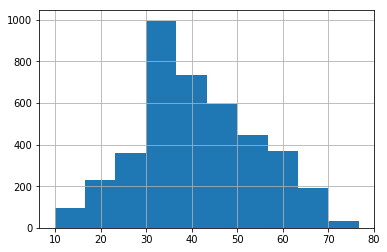

In [18]:
np.power(salary_df['salary'], 1/4).hist();

### City information
When thinking about race, we considered whether the demographics of the city influence player popularity. I downloaded census and polling data for both NBA and NFL cities (I forgot the sites). I then spent some time making sure all the join keys were correct.
#### City demographics

In [19]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

#### City voting during 2016 election

In [33]:
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

### Combine info
After getting all of the data for various covariates, I combined them into a single dataframe that has performance, demographics, and city information.

In [34]:
covariates_df = (demo_df.merge(performance_df, on = 'Player')
                      .merge(team_df, on=['Tm', 'year'])
                      .merge(city_df, on='Tm')
                      .merge(vote_df, on='Tm') )
covariates_df['Player'] = covariates_df['Player'].str.replace('.', '')
covariates_df = covariates_df.merge(salary_df, on=['Player', 'season'], how='left')
covariates_df['experience'] = covariates_df['year'] - covariates_df['From']
covariates_df.head(2)

,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,...,year,season,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,alex abrines,W,2017,2018,G-F,78,190,"August 1, 1993",NaN,1,...,2017,2016,47,1337075,74.1,10.2,0.1051,5994764.0,49.481519,0
1,steven adams,W,2014,2018,C,84,255,"July 20, 1993",University of Pittsburgh,3,...,2017,2016,47,1337075,74.1,10.2,0.1051,3140517.0,42.096917,3


### Coach data
In addition to getting player data, I wanted to get coach data. For coaches, we have fewer features (just wins). Here, I wrote a simple function to scrape basketball-reference.com, `scrape_nba_coaches`. 

In [ ]:
%%time
importlib.reload(spd)
nba_coach_df = spd.scrape_nba_coaches()
nba_coach_df.to_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t', index=False)

## NFL data
In addition to understanding what drives NBA player sentiment, I wanted to look at other sports, specifically the NFL. Rather than step through each individual function to scrape the data, I would instead refer you to the `scrape_player_data` module.

## Data for download
As the covariate data is rather small, and all publicly sourced, I have uploaded it to the github repo for this project: `map222/trailofpapers/sentiment_spors/modeling_data`.

## Appendiex
### Use PRAW and reddit API to get lots of comments
Before using pushshift, I used the actual reddit API. Unfortunately, an API update broke this code. If you figure out how to run this, let me know!

In [1]:
import time
from datetime import datetime
import json
import pandas as pd
import praw # for direct reddit pull

In [2]:
client_id = 'nope'
secret = 'nope'
user_agent = 'r/nba race sentiment 0.1 by /u/Umiy'

In [3]:
r = praw.Reddit(user_agent=user_agent, client_id=client_id, client_secret=secret)
r_nba = r.subreddit('nba')

In [138]:
def parse_submission( submission):
    text = submission.title + '. ' + submission.selftext
    creation_date = submission.created
    author = submission.author #.name for PRAW
    flair = submission.author_flair_text
    score = submission.score
    return (text, creation_date, author, flair, score)

In [140]:
def parse_comment( comment):
    if hasattr(comment, 'body') and comment.author != None:
        text = comment.body
        creation_date = comment.created
        author = comment.author
        flair = comment.author_flair_text
        score = comment.score
        return (text, creation_date, author, flair, score)
    return ('', 1, '', '', 0)

In [6]:
def get_month(year, month, month_length):
    ''' Get comments and submissions for one month. takes ~ 1h 15 minutes.
    '''
    data_col = ['text', 'timestamp', 'user', 'flair']
    print('Downloading submssions for {}-{}'.format(year, month))
    month_submissions = [list(r_nba.submissions(datetime(year,month,day).timestamp(), datetime(year,month,day+1).timestamp() )) for day in range(1,month_length)]
    month_submissions = [x for day_submissions in month_submissions for x in day_submissions]
    
    print('Downloaded {} submissions'.format(len(month_submissions)))
    ops = [ parse_submission(submission) for submission in month_submissions]
    submission_df =(pd.DataFrame(ops, columns=data_col)
                      .assign(source = lambda x: 'submission') )
    print('Made dataframe of shape {}'.format(submission_df.shape) )
    
    print('Downloading comments (this could take an hour)')
    comments_list = [submission.comments.list() for submission in month_submissions if hasattr(submission, 'comments')]
    comments = [ parse_comment(comment) for comments in  comments_list for comment in comments]
    print('Downloaded {} comments'.format(len(comments) ) )
    comment_df = (pd.DataFrame(comments, columns=data_col)
                    .assign(source = lambda x: 'comment') )
    return pd.concat([submission_df, comment_df]), ops, comments

In [ ]:
%%time
# this no longer works 
month_df, submissions, comments = get_month(2017, 11, 30)